## 8.2 Identifying seasonal patterns in a time series

Intuitively, we know that it makes sense to apply the SARIMA model on data that exhibits a seasonal pattern. Therefore, it is important to determine ways to identify seasonality in time series.

Usually, plotting the time series data is enough to observe periodic patterns. Another way of identifying seasonal patterns in a time series is using time series decomposition, a method that we first used in chapter 1. Time series decomposition is a statistical task that separates the time series into its three main components: a trend component, a seasonal component, and the residuals.

The trend component represents the long-term change in the time series. This component is responsible for time series that increase or decrease over time. The seasonal component is, of course, the seasonal pattern in the time series. It represents repeated fluctuations that occur over a fixed period of time. Finally, the residuals, or the noise, express any irregularity that cannot be explained by the trend or the seasonal component.

With time series decomposition, we can clearly identify and visualize the seasonal component of a time series. We can decompose the dataset for air passengers using the STL function from the statsmodels library

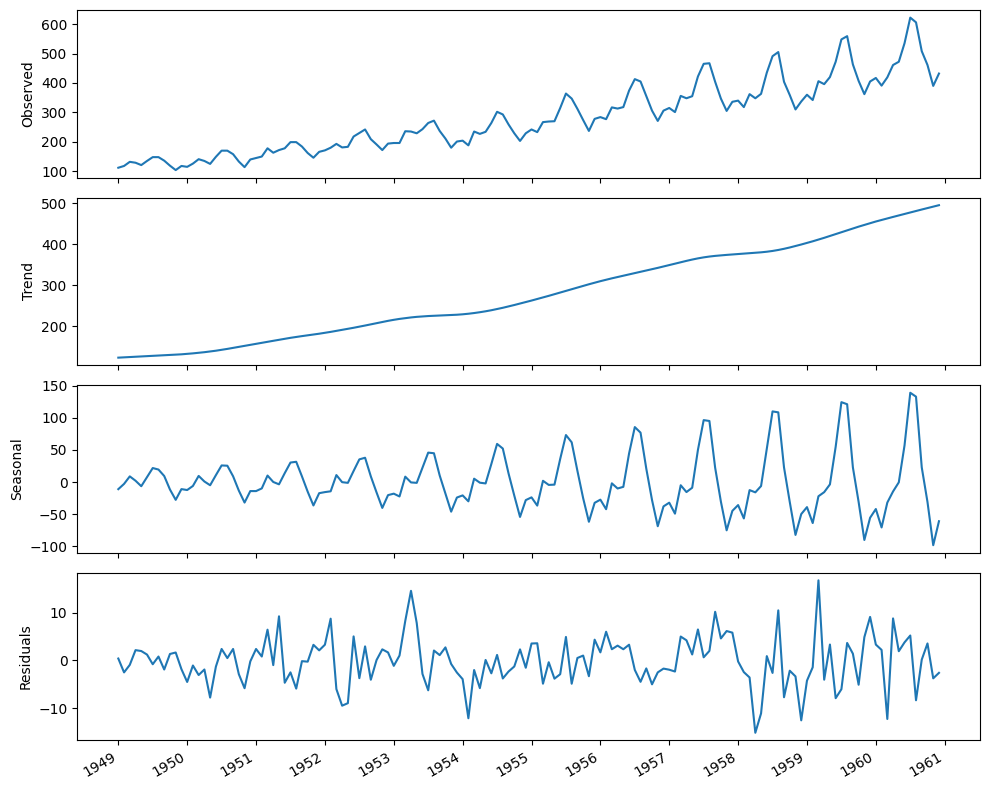

In [1]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df = pd.read_csv('./air-passengers.csv')

decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
## 8.3 Forecasting the number of monthly air passengers

In the previous chapter, we adapted our general modeling procedure to account for the new parameter d in the ARIMA model that allows us to forecast non-stationary time series. The steps are outlined in figure 8.6. Now we must modify it again to account for the new parameters of the SARIMA model, which are P, D, Q, and m.

The first step of gathering data remains untouched. Then we still check for stationarity and apply transformation in order to set the parameter d. However, we can also perform seasonal differencing to make the series stationary, and D will be equal to the
minimum number of times we applied seasonal differencing.

Then we set a range of possible values for p, q, P, and Q, as the SARIMA model can also incorporate the order of the seasonal autoregressive and seasonal moving average processes. Note that the addition of these two new parameters will increase the number of unique combinations of SARIMA(p,d,q)(P,D,Q)m models we can fit, so this step will take longer to complete. The rest of the procedure remains the same, as we still need to select the model with the lowest AIC and perform residual analysis before using the model for forecasting. 

With our new modeling procedure defined, we are now ready to forecast the total number of monthly air passengers. For this scenario, we wish to forecast 1 year of monthly air passengers, so we will use the data from 1960 as the test set.

The baseline model will be the naive seasonal forecast, and we will use both the ARIMA(p,d,q) and SARIMA(p,d,q)(P,D,Q)m models to verify whether the addition of seasonal components will yield better forecasts.

### 8.3.1 Forecasting with an ARIMA(p,d,q) model

We’ll first model the dataset using an ARIMA(p,d,q) model. That way, we can compare its performance to the SARIMA(p,d,q)(P,D,Q)m model. Following the general modeling procedure we outlined before, we’ll first test for stationarity. Again, we use the ADF test.

In [2]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


This prints out an ADF statistic of 0.82 and a p-value of 0.99. Therefore, we cannot reject the null hypothesis and the series is not stationary. We’ll difference the series and test for stationarity again.

In [3]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


This returns an ADF statistic of –2.83 and a p-value of 0.054. Again, we cannot reject the null hypothesis, and differencing the series once did not make it stationary. Therefore, we’ll difference it again and test for stationarity.

In [5]:
df_diff2 = np.diff(df['Passengers'], n=2)

ad_fuller_result = adfuller(df_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -16.384231542468513
p-value: 2.7328918500142026e-29


This returns an ADF statistic of –16.38 and a p-value of 2.73 × 10–29. Now we can reject the null hypothesis, and our series is considered to be stationary. Since the series was differenced twice to become stationary, d = 2.

Now we can define a range of possible values for the parameters p and q and fit all unique ARIMA(p,d,q) models. We’ll specifically choose a range from 0 to 12 to allow the ARIMA model to go back 12 timesteps in time. Since the data is sampled monthly and we know it is seasonal, we can hypothesize that the number of air passengers in January of a given year is likely predictive of the number of air passengers in January of the following year. Since these two points are 12 timesteps apart, we’ll allow the values of p and q to vary from 0 to 12 in order to potentially capture this seasonal information in the ARIMA(p,d,q) model. Finally, since we are working with an ARIMA model, we’ll set P, D, and Q to 0. Note the use of the parameter s in the following code, which is equivalent to m. The implementation of SARIMA in statsmodels simply uses s instead of m—they both denote the frequency.

In [11]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)

Ps = [0]
Qs = [0]

d = 2
D = 0

s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

You’ll notice that we set the parameters P, D, Q, and m, even though we are working with an ARIMA model. This is because we are going to define an optimize_SARIMA function that will then be reused in the next section. We set P, D, and Q to 0 because a SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model. 

The optimize_SARIMA function builds on the optimize_ARIMA function that we defined in the previous chapter. This time, we’ll integrate the possible values of P and Q, as well as add the seasonal order of integration D and the frequency m. The function is shown in the following listing.

In [9]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

With the function ready, we can launch it using the train set and get the ARIMA model with the lowest AIC. Despite the fact that we are using the optimize_SARIMA function, we are still fitting an ARIMA model because we specifically set P, D, and Q to 0.

For the train set, we’ll take all data points but the last twelve, as they will be used for the test set.

In [10]:
train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.901297
1,"(11, 4, 0, 0)",1019.013096
2,"(12, 0, 0, 0)",1020.199046
3,"(11, 5, 0, 0)",1020.428000
4,"(11, 1, 0, 0)",1021.029641
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


This returns a DataFrame where the model with the lowest AIC is a SARIMA(11,2,3)(0,0,0)12 model, which is equivalent to an ARIMA(11,2,3) model. As you can see, allowing the order p to vary from 0 to 12 was beneficial for the model, as the model with the lowest AIC takes into account the past 11 values of the series, since p = 11. We will see if this is enough to capture seasonal information from the series, and we will compare the performance of the ARIMA model to the SARIMA model in the next section.

For now, we’ll focus on performing residual analysis. We can fit the ARIMA(11,2,3) model obtained previously and plot the residuals’ diagnostics.

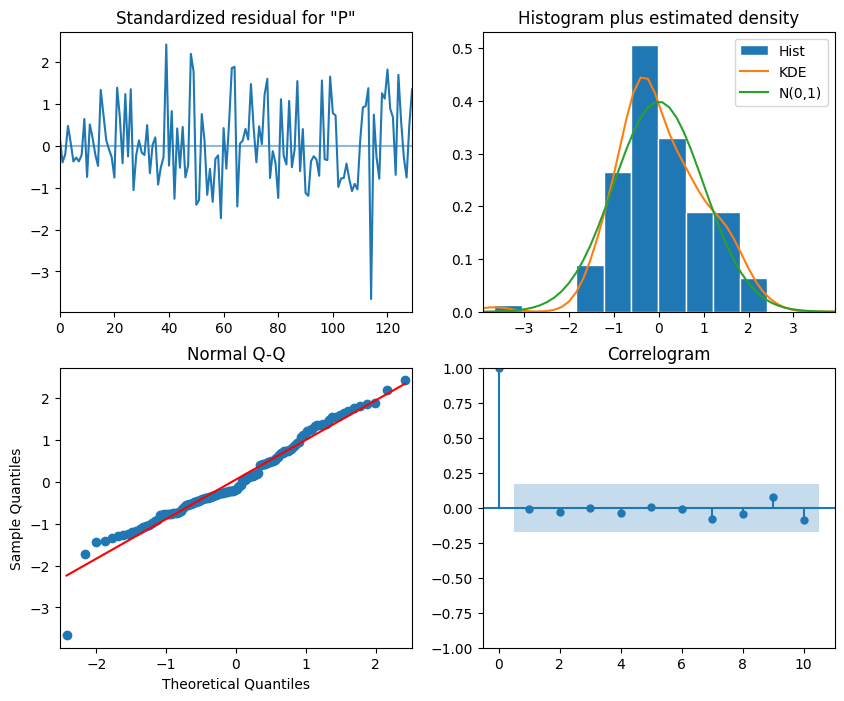

In [14]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

The next step is to run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated.

In [15]:
residuals = ARIMA_model_fit.resid
pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

      lb_stat  lb_pvalue
1    6.568643   0.010379
2    6.685297   0.035343
3    6.934676   0.074009
4    7.766679   0.100509
5    8.398155   0.135615
6    8.723460   0.189738
7    9.603887   0.212154
8    9.829592   0.277191
9    9.838922   0.363682
10  11.630243   0.310565


The returned p-values are all greater than 0.05 except for the first two values. This means that, according to the Ljung-Box test, we reject the null hypothesis with a 5% chance of being wrong, since we set our significance boundary to 0.05. However, the third value and onwards are all greater than 0.05, so we reject the null hypothesis, concluding that the residuals are uncorrelated starting at lag 3.

This is an interesting situation to dissect, because the graphical analysis of the residuals leads us to conclude that they resemble white noise, but the Ljung-Box test points to some correlation at lags 1 and 2. This means that our ARIMA model is not capturing all the information from the data. In this case, we’ll move forward with the model, because we know that we are modeling seasonal data with a non-seasonal model. Therefore, the Ljung-Box test is really telling us that our model is not perfect, but that’s okay, because part of this exercise is to compare the performance of ARIMA and SARIMA and demonstrate that SARIMA is the way to go when dealing with seasonal data.

As previously mentioned, we wish to predict a full year of monthly air passengers, using the last 12 months of data as our test set. The baseline model is the naive seasonal forecast, where we simply use the number of air passengers for each month of 1959 as a forecast for each month of 1960.

In [16]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values

ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred

### 8.3.2 Forecasting with a SARIMA(p,d,q)(P,D,Q)m model

In the previous section, we used an ARIMA(11,2,3) model to forecast the number of monthly air passengers. Now we’ll fit a SARIMA model and see if it performs better than the ARIMA model.

Following the steps in our general modeling procedure, we’ll first check for stationarity and apply the required transformations.

In [17]:
ad_fuller_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


The ADF test on the dataset returns an ADF statistic of 0.82 and a p-value of 0.99. Therefore, we cannot reject the null hypothesis and the series is not stationary. We can apply a first-order differencing and test for stationarity.

In [18]:
df_diff = np.diff(df['Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -2.8292668241700047
p-value: 0.05421329028382478


This returns an ADF statistic of –2.83 and a p-value of 0.054. Since the p-value is greater than 0.05, we cannot reject the null hypothesis, and the series is still nonstationary. Therefore, let’s apply a seasonal difference and test for stationarity.

In [19]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -17.62486236026156
p-value: 3.823046855601547e-30


This returns an ADF statistic of –17.63 and a p-value of 3.82 × 10–30. With a large and negative ADF statistic and a p-value smaller than 0.05, we can reject the null hypothesis and consider the transformed series as stationary. Therefore, we performed one
round of differencing, meaning that d = 1, and one round of seasonal differencing, meaning that D = 1.

With this step done, we can now define the range of possible values for p, q, P, and Q, fit each unique SARIMA(p,d,q)(P,D,Q)m model, and select the one with the lowest AIC.

In [20]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.245959
1,"(2, 1, 2, 1)",893.566141
2,"(2, 1, 1, 3)",894.091159
3,"(1, 0, 1, 2)",894.288976
4,"(0, 1, 1, 2)",894.993989
...,...,...
251,"(0, 0, 2, 0)",906.940147
252,"(3, 2, 0, 3)",907.181875
253,"(0, 0, 3, 2)",907.473272
254,"(0, 0, 3, 0)",908.742583


Once the function is done running, we find that the SARIMA(2,1,1)(1,1,2)12 model has the lowest AIC, which is a value of 892.24. We can fit this model again on the training set to perform residual analysis.

We’ll start by plotting the residuals diagnostics

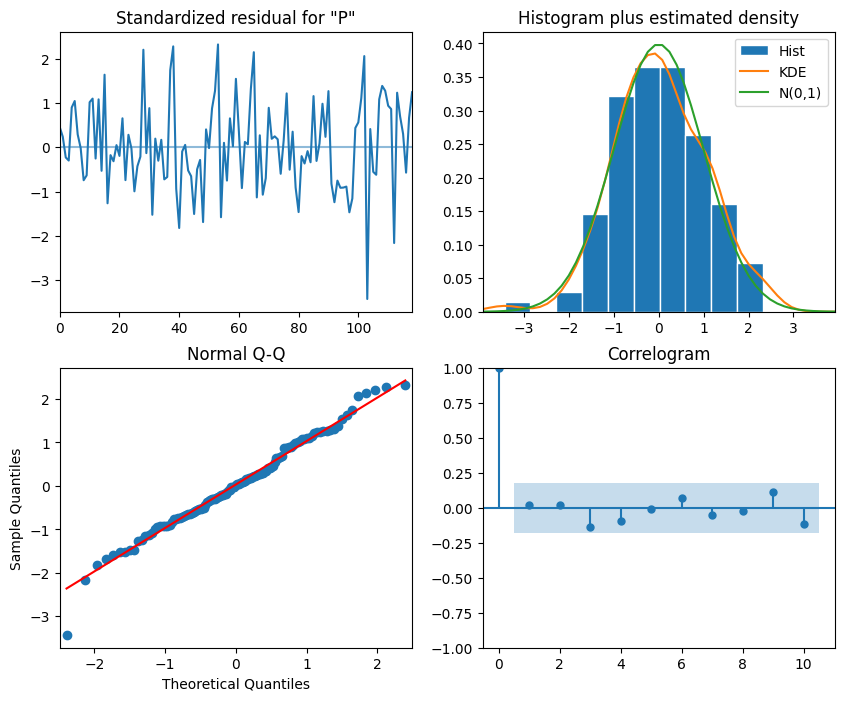

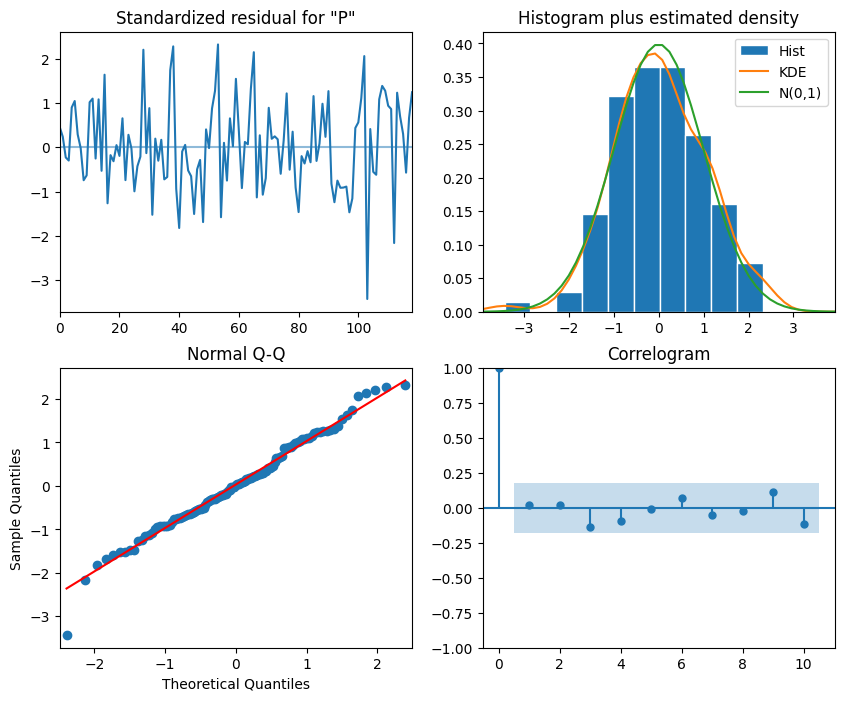

In [21]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)

SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

The results show that our residuals are completely random, which is exactly what we are looking for in a good model.

The final test to determine whether we can use this model for forecasting or not is the Ljung-Box test.

In [22]:
residuals = SARIMA_model_fit.resid

pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

     lb_stat  lb_pvalue
1   0.004624   0.945787
2   0.743627   0.689483
3   1.017290   0.797068
4   1.222999   0.874298
5   1.435232   0.920421
6   1.709511   0.944385
7   2.303370   0.941162
8   2.713679   0.951022
9   2.729304   0.974068
10  4.966671   0.893393


The returned p-values are all greater than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated, just like white noise.

Our model has passed all the tests from the residuals analysis, and we are ready to use it for forecasting. Again, we’ll forecast the number of monthly air passengers for the year of 1960 to compare the predicted values to the observed values in the test set.

In [23]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred

Now that we have the results, we can compare the performance of each model and determine the best forecasting method for our problem.

### 8.3.3 Comparing the performance of each forecasting method

We can now compare the performance of each forecasting method: the naive seasonal forecasts, the ARIMA model, and the SARIMA model. We’ll use the mean absolute percentage error (MAPE) to evaluate each model.
We can first visualize the forecasts against the observed values of the test set.

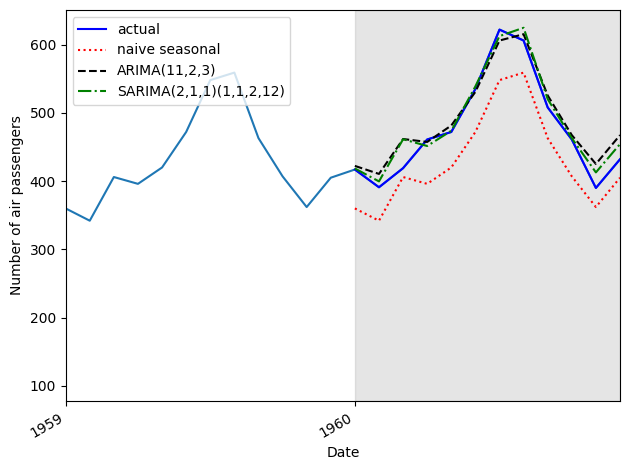

In [24]:
fig, ax = plt.subplots()

ax.plot(df['Month'], df['Passengers'])
ax.plot(test['Passengers'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

We can measure the MAPE of each model and display it in a bar plot

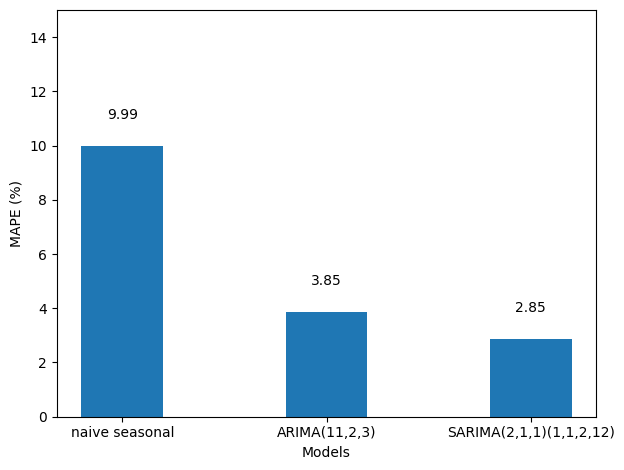

In [25]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mape(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Passengers'], test['SARIMA_pred'])

fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

You can see that our baseline achieves a MAPE of 9.99%. The ARIMA model produced forecasts with a MAPE of 3.85%, and the SARIMA model scored a MAPE of 2.85%. A MAPE closer to 0 is indicative of better predictions, so the SARIMA model is the best-performing method for this situation. This makes sense, since our dataset had clear seasonality, and the SARIMA model is built to use the seasonal properties of time series to make forecasts.